In [2]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
from natsort import natsorted
from skimage import io
import matplotlib.pyplot as plt
import cv2 as cv
import h5py

Paths are for dataset tagged: all


['C:\\AIND\\output_data\\636970\\20221128\\metadata2022-11-28T15_28_04.csv']
[1261]


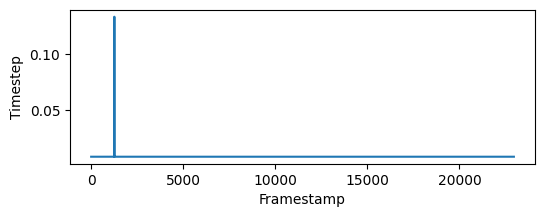

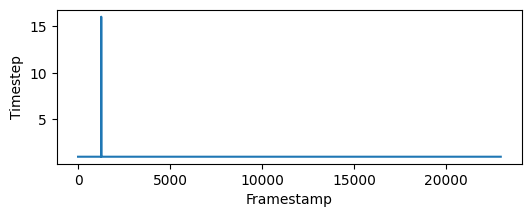

1864
128
244
504


In [3]:
# Read metadata files and extract timestamp of each frame
metadata_file = glob.glob(os.path.join(paths['raw_data'],'*.csv'))
print(metadata_file)
metadata = pd.read_csv(metadata_file[0])
timestamp = metadata.CameraTimestampSeconds + 10**-6*metadata.CameraTimestampMicroSeconds
time_vector = timestamp - timestamp[0]

framestamp = np.asarray(metadata.Framestamp)
skip_frames = np.asarray(np.where(np.diff(framestamp) > 1))
skip_frames = skip_frames.flatten() +1
print(skip_frames)

f, ax = plt.subplots(figsize=(6,2))
ax.plot(np.diff(time_vector))
ax.set(xlabel='Framestamp', ylabel='Timestep')
plt.show()

f, ax = plt.subplots(figsize=(6,2))
ax.plot(np.diff(framestamp))
ax.set(xlabel='Framestamp', ylabel='Timestep')
plt.show()

width = metadata.Width[0]
print(width)
Xoffset = metadata.XOffset[0]
print(Xoffset)
height = metadata.Height[0]
print(height)
Yoffset = metadata.YOffset[0]
print(Yoffset)

In [4]:
# Read tiff files and extract intensity at each frame and pixel
files = os.listdir(paths['raw_data'])
print(files)
tiff_dir = os.path.join(paths['raw_data'],files[1])
tiff_files = os.listdir(tiff_dir)
tiff_files = np.array(natsorted(tiff_files))
tiff_files

['20221128.txt', 'bigTiffs', 'metadata2022-11-28T15_28_04.csv']


array(['Tiff0.tif', 'Tiff1.tif', 'Tiff2.tif', 'Tiff3.tif', 'Tiff4.tif',
       'Tiff5.tif', 'Tiff6.tif', 'Tiff7.tif', 'Tiff8.tif', 'Tiff9.tif',
       'Tiff10.tif', 'Tiff11.tif', 'Tiff12.tif', 'Tiff13.tif',
       'Tiff14.tif', 'Tiff15.tif', 'Tiff16.tif', 'Tiff17.tif',
       'Tiff18.tif', 'Tiff19.tif', 'Tiff20.tif', 'Tiff21.tif',
       'Tiff22.tif'], dtype='<U10')

In [5]:
# Unskew image, rotation followed by affine transformation

# Copied from running preprocess_01_unskewimage
theta_r = -1.0299255407903252
pt1 = [937-Xoffset, 572-Yoffset] 
pt2 = [910-Xoffset, 687-Yoffset] 
pt3 = [1114-Xoffset, 573-Yoffset] 
pt4 = [910-Xoffset, 572-Yoffset] 
pt5 = [910-Xoffset, 687-Yoffset] 
pt6 = [1084-Xoffset, 573-Yoffset]
fiber1_location = [620-Yoffset,580-Yoffset]
fiber2_location = [670-Yoffset,630-Yoffset]

# Load data and unskew
rows,cols = [height, width]
M1 = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),theta_r,1)
pts1 = np.float32([pt1, pt2, pt3])
pts2 = np.float32([pt4, pt5, pt6])
M2 = cv.getAffineTransform(pts1,pts2)

num_files = np.size(tiff_files,0)
tiff_file_path = os.path.join(tiff_dir,tiff_files[-1])
temp = io.imread(tiff_file_path).astype(float)
sz_x = 1000*(num_files-1) + temp.shape[0]
sz_y = width
fiber1 = np.zeros([sz_x, sz_y])
fiber2 = np.zeros([sz_x, sz_y])
for seq in range(0,np.size(tiff_files,0)):
    print(seq)
    tiff_file_path = os.path.join(tiff_dir,tiff_files[seq])
    temp = io.imread(tiff_file_path).astype(float)
    for frame in range(0,np.size(temp,0)):
        temp_rotated = cv.warpAffine(temp[frame,:,:],M1,(cols,rows))
        img = cv.warpAffine(temp_rotated,M2,(cols,rows))
        fiber1_m = np.mean(img[fiber1_location[1]:fiber1_location[0],:],axis=0)
        fiber2_m = np.mean(img[fiber2_location[1]:fiber2_location[0],:],axis=0)
        fiber1_m = np.expand_dims(fiber1_m, axis=0)
        fiber2_m = np.expand_dims(fiber2_m, axis=0)
        if seq == 0:
            fiber1[frame,:] = fiber1_m
            fiber2[frame,:] = fiber2_m
        else:
            fiber1[seq*1000 + frame,:] = fiber1_m
            fiber2[seq*1000 + frame,:] = fiber2_m

print(fiber1.shape)
print(fiber2.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
(22963, 1864)
(22963, 1864)


1


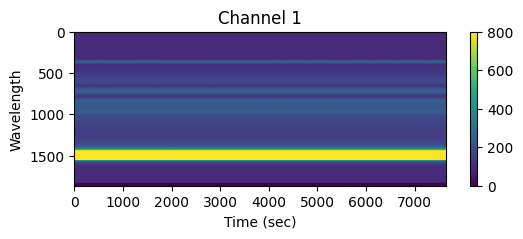

In [6]:
# Interleave signals into individual lasers
num_lasers = 5
print(skip_frames.size)
if skip_frames.size == skip_frames.size:
    img_new = fiber1
else:
    # Insert nan in skipped frames
    for skip in skip_frames:
        print(skip)
        img_new = np.insert(fiber1,skip,np.nan,axis=0)

ch1 = img_new[0::3,:]
ch2 = img_new[1::3,:]
ch3 = img_new[2::3,:]
ch4 = img_new[3::3,:]
ch5 = img_new[4::3,:]
ch1.shape

f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(ch1), aspect='auto', vmin=0, vmax=800)
ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='Channel 1')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

7654

Time
[8.33201408e-03 3.33359241e-02 5.83400726e-02 ... 1.91414093e+02
 1.91439096e+02 1.91464100e+02]

Wavelength
[400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453
 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471
 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489
 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597
 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616

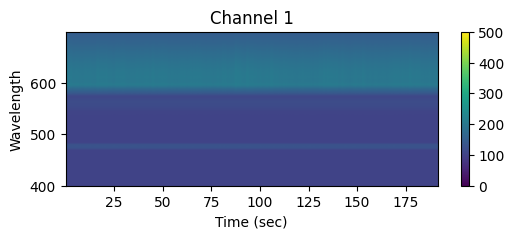

In [7]:
# Save pre-processed data hdf5
# To save: time vector, wavelength, intensity

cut = np.min([ch1.shape[0],ch2.shape[0],ch3.shape[0],ch4.shape[0],ch5.shape[0]])
print(cut)
time = time_vector[1::5]
time = time.iloc[0:cut].to_numpy()

c = pd.read_hdf(paths['root']/'pixel_to_nm.hdf5', key='Camera_pixel', more='r')
w = pd.read_hdf(paths['root']/'pixel_to_nm.hdf5', key='Wavelength_nm', more='r')
wavelength = w.to_numpy()
camera_px = c.to_numpy()

Channel1 = np.zeros([cut,wavelength.shape[0]]).astype('int')
Channel2 = np.zeros([cut,wavelength.shape[0]]).astype('int')
Channel3 = np.zeros([cut,wavelength.shape[0]]).astype('int')
Channel4 = np.zeros([cut,wavelength.shape[0]]).astype('int')
Channel5 = np.zeros([cut,wavelength.shape[0]]).astype('int')
for px in range(0,wavelength.shape[0]):
    Channel1[:,px] = ch1[0:cut,camera_px[px]-Xoffset]
    Channel2[:,px] = ch2[0:cut,camera_px[px]-Xoffset]
    Channel3[:,px] = ch3[0:cut,camera_px[px]-Xoffset]
    Channel4[:,px] = ch4[0:cut,camera_px[px]-Xoffset]
    Channel5[:,px] = ch5[0:cut,camera_px[px]-Xoffset]

data_preprocessed = {'Time':time, 'Wavelength':wavelength, 'Channel1':Channel1, 'Channel2':Channel2, 'Channel3':Channel3, 'Channel4':Channel4, 'Channel5':Channel5}
for key in data_preprocessed.keys():
    print(f'\n{key}')
    print(data_preprocessed[key])
    
f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(Channel2), aspect='auto', vmin=0, vmax=500, extent=[np.min(time), np.max(time), 699, 400])
ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='Channel 1', ylim=[400,699])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

hf = h5py.File(paths['raw_data'] / 'data_preprocessed.hdf5','a')
for key in data_preprocessed.keys():
    hf.create_dataset(key, data = data_preprocessed[key])
hf.close()

In [8]:
with h5py.File(paths['raw_data']/'data_preprocessed.hdf5','r') as f:
    print(f.keys())

f = h5py.File(paths['raw_data'] / 'data_preprocessed.hdf5','r')
channel_1 = f['Channel1']
print(channel_1.shape)
channel_2 = f['Channel2']
print(channel_2.shape)
channel_3 = f['Channel3']
print(channel_3.shape)
channel_4 = f['Channel4']
print(channel_3.shape)
channel_5 = f['Channel5']
print(channel_3.shape)
time = f['Time']
print(time.shape)
wavelength = f['Wavelength']
print(wavelength.shape)

print(time[-1])

<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Time', 'Wavelength']>
(7654, 300)
(7654, 300)
(7654, 300)
(7654,)
(300,)
191.4640998840332


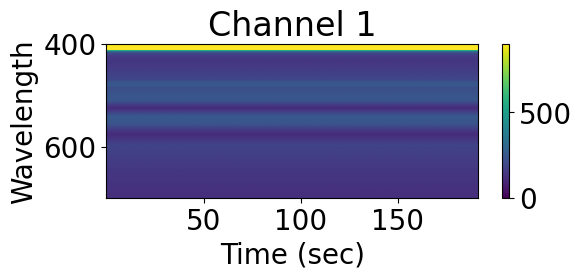

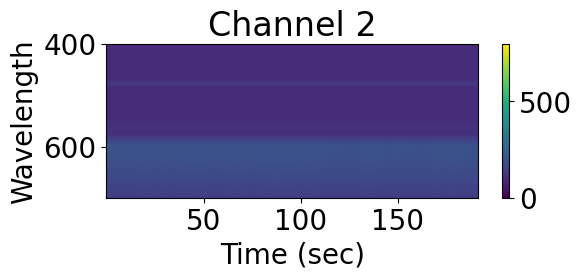

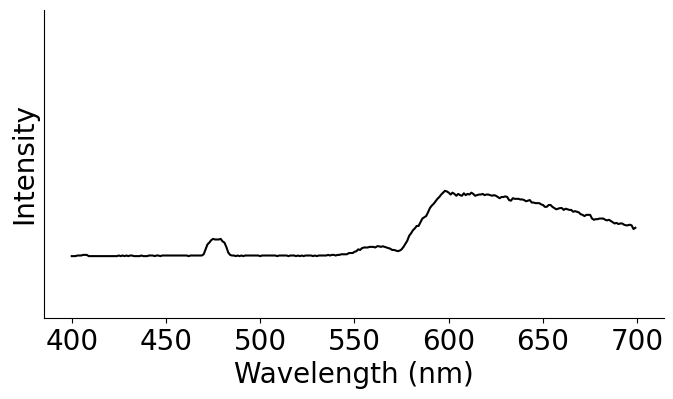

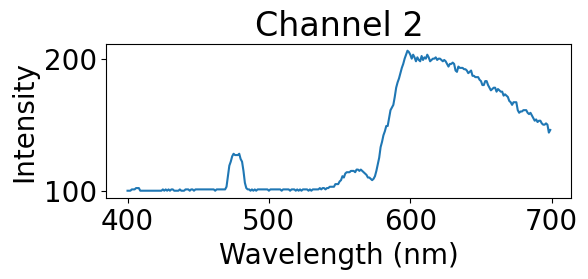

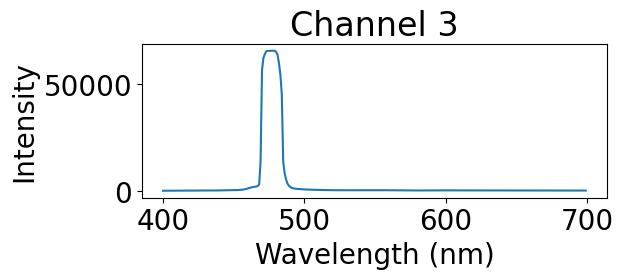

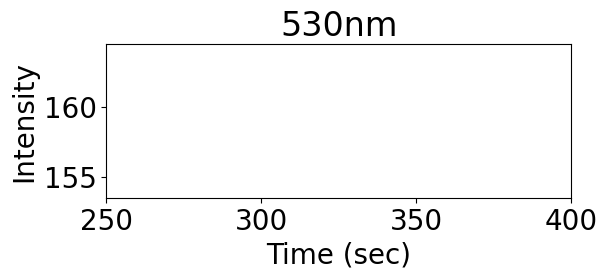

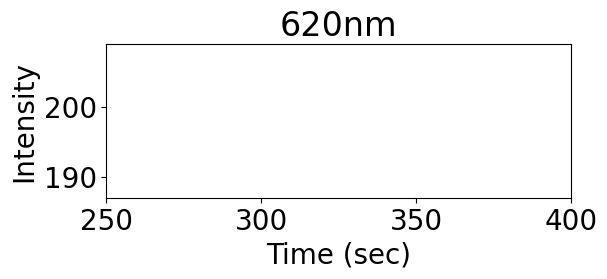

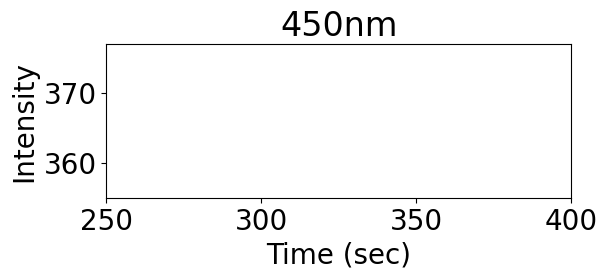

In [26]:
f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(channel_1), aspect='auto', vmin=0, vmax=900, extent=[np.min(time), np.max(time), 699, 400])
ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='Channel 1')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(channel_2), aspect='auto', vmin=0, vmax=800, extent=[np.min(time), np.max(time), 699, 400])
ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='Channel 2')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(8,4))
ax.plot(wavelength[:], channel_2[10,:],color='k')
ax.set(xlabel='Wavelength (nm)', ylabel='Intensity', ylim=[0,500])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.rcParams.update({'font.size': 20})
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(wavelength[:], channel_2[10,:])
ax.set(xlabel='Wavelength (nm)', ylabel='Intensity', title='Channel 2')
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(wavelength[:], channel_3[10,:])
ax.set(xlabel='Wavelength (nm)', ylabel='Intensity', title='Channel 3')
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], channel_1[:,530-400], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity', title='530nm', xlim=[250,400])
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], channel_2[:,620-400], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity', title='620nm', xlim=[250,400])
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], channel_3[:,450-400], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity', title='450nm', xlim=[250,400])
plt.show()